# Imports necesarios

In [14]:
# 1. Para manejar los datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

# Análisis de los datos

In [9]:
path = "/home/edgar/GitHub/Proyectos/Hackathon_salud/archive/Chronic_Kidney_Dsease_data.csv"
df = pd.read_csv(path)
print(df.head())

   PatientID  Age  Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0          1   71       0          0                    0               2   
1          2   34       0          0                    1               3   
2          3   80       1          1                    0               1   
3          4   40       0          2                    0               1   
4          5   43       0          1                    1               2   

         BMI  Smoking  AlcoholConsumption  PhysicalActivity  ...   Itching  \
0  31.069414        1            5.128112          1.676220  ...  7.556302   
1  29.692119        1           18.609552          8.377574  ...  6.836766   
2  37.394822        1           11.882429          9.607401  ...  2.144722   
3  31.329680        0           16.020165          0.408871  ...  7.077188   
4  23.726311        0            7.944146          0.780319  ...  3.553118   

   QualityOfLifeScore  HeavyMetalsExposure  OccupationalExposureChem

In [10]:
Lista_pacientes_negativos = []
Lista_pacientes_positivos = []


df = df.drop(columns=['PatientID', 'DoctorInCharge'])

print(df["Diagnosis"][10])
for i in range (len(df.index)):
    if df["Diagnosis"][i] == 0:
        Lista_pacientes_negativos.append(df.iloc[i,:])
    else:
        Lista_pacientes_positivos.append(df.iloc[i,:])




1


# Separar Datos

In [ ]:
# Separar características y etiquetas

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# ==========================================
# 2. DIVISIÓN DE DATOS
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Balance tras ADASYN en Train: {0: 1237, 1: 1219}


# Implemetación de Adasyn


In [ ]:


# ==========================================
# 3. APLICAR ADASYN
# ==========================================
try:
    # sampling_strategy='auto' intenta equilibrar al 50/50
    adasyn = ADASYN(random_state=42, sampling_strategy='auto')
    X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
    
    print(f"Balance tras ADASYN en Train: {y_train_res.value_counts().to_dict()}")

except ValueError as e:
    print(f"Error en ADASYN: {e}")
    print("Nota: ADASYN requiere al menos n_neighbors muestras de la clase minoritaria.")
    X_train_res, y_train_res = X_train, y_train

# Implementación de Smote

In [16]:
smote = SMOTE(random_state=42, k_neighbors=5)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Train tras SMOTE: {y_train_smote.value_counts().to_dict()}")

Train tras SMOTE: {1: 1219, 0: 1219}


# Implementación de Random Forest (datos de Adasyn)

In [12]:
# ==========================================
# 4. ENTRENAR EL RANDOM FOREST
# ==========================================
print("\nEntrenando Random Forest...")

# Configuración robusta del modelo
rf_model = RandomForestClassifier(
    n_estimators=200,    # Número de árboles (más suele ser mejor, hasta cierto punto)
    max_depth=None,      # Profundidad máxima (None = hasta que aprenda todo)
    min_samples_split=5, # Evita overfitting (no dividir nodos muy pequeños)
    random_state=42,
    n_jobs=-1            
)

rf_model.fit(X_train_res, y_train_res)


Entrenando Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluación Random Forest (Adasyn)


--- REPORTE DE CLASIFICACIÓN ---
              precision    recall  f1-score   support

           0       0.56      0.19      0.28        27
           1       0.93      0.99      0.96       305

    accuracy                           0.92       332
   macro avg       0.74      0.59      0.62       332
weighted avg       0.90      0.92      0.90       332



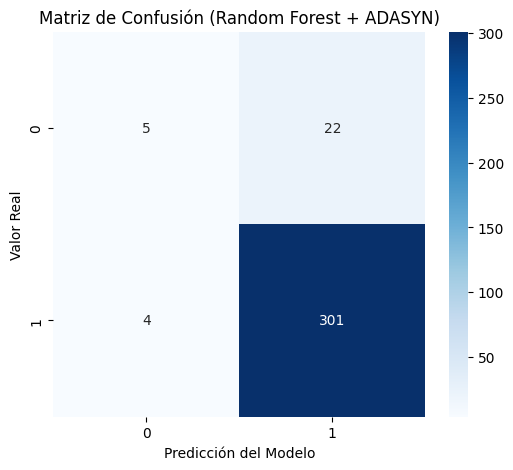


--- TOP 5 VARIABLES MÁS IMPORTANTES ---
GFR                0.095528
SerumCreatinine    0.073752
Itching            0.060924
Gender             0.049101
Diuretics          0.035506
dtype: float64


In [19]:
# Predecimos usando los datos de TEST (que son reales, no sintéticos)
y_pred = rf_model.predict(X_test)

# A) Reporte Numérico
print("\n--- REPORTE DE CLASIFICACIÓN ---")
print(classification_report(y_test, y_pred))

# B) Matriz de Confusión Gráfica
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Random Forest + ADASYN)')

plt.show()

# C) Importancia de Variables (¿Qué columnas pesaron más?)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\n--- TOP 5 VARIABLES MÁS IMPORTANTES ---")
print(feature_importances.nlargest(5))

# Implementación Random Forest (Smote)

In [17]:
# ==========================================
# 4. ENTRENAR EL RANDOM FOREST
# ==========================================
print("\nEntrenando Random Forest...")

# Configuración robusta del modelo
rf_model2 = RandomForestClassifier(
    n_estimators=200,    # Número de árboles (más suele ser mejor, hasta cierto punto)
    max_depth=None,      # Profundidad máxima (None = hasta que aprenda todo)
    min_samples_split=5, # Evita overfitting (no dividir nodos muy pequeños)
    random_state=42,
    n_jobs=-1            
)

rf_model2.fit(X_train_smote, y_train_smote)


Entrenando Random Forest...


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluación random forest (Smote)


--- REPORTE DE CLASIFICACIÓN (SMOTE) ---
              precision    recall  f1-score   support

           0       0.40      0.15      0.22        27
           1       0.93      0.98      0.95       305

    accuracy                           0.91       332
   macro avg       0.66      0.56      0.58       332
weighted avg       0.89      0.91      0.89       332



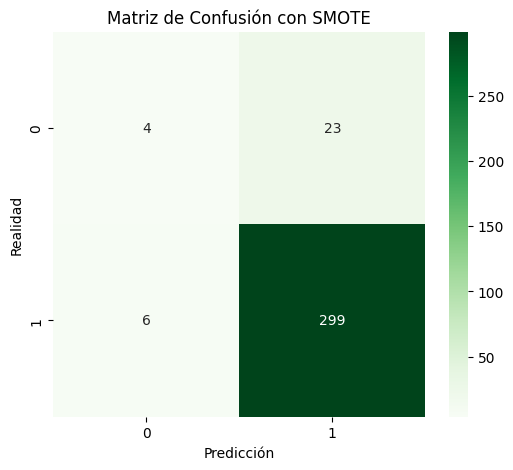

In [18]:
# ==========================================
# 6. EVALUAR
# ==========================================
y_pred_smote = rf_model2.predict(X_test)

print("\n--- REPORTE DE CLASIFICACIÓN (SMOTE) ---")
print(classification_report(y_test, y_pred_smote))

# Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión con SMOTE')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()